# Explore UR5e table data

## Init

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm
import numpy as np

In [2]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore

In [3]:
from rosbags.highlevel import AnyReader

In [4]:
# from PIL import Image
import cv2
import datetime

## Get data

In [5]:
data_path = Path("../table-task-ur5e")
data_path.exists()

True

In [6]:
bagfiles = list(data_path.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [7]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [8]:
def extract_eef_data_from_rosbag(bagfile):
    tf = {"x": [], "y": [], "z": [], "timestamp": []}
    gripper = {"val": [], "timestamp": []}

    # Create a type store to use if the bag has no message definitions.
    typestore = get_typestore(Stores.ROS1_NOETIC)

    # Create reader instance and open for reading.
    with AnyReader([bagfile], default_typestore=typestore) as reader:
        connections = [x for x in reader.connections if x.topic == "/imu_raw/Imu"]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            # print(msg.header.frame_id
            if connection.msgtype == "tf2_msgs/msg/TFMessage":
                if (
                    msg.transforms[0].child_frame_id == "tool0_controller"
                    and msg.transforms[0].header.frame_id == "base"
                ):
                    tf["x"].append(msg.transforms[0].transform.translation.x)
                    tf["y"].append(msg.transforms[0].transform.translation.y)
                    tf["z"].append(msg.transforms[0].transform.translation.z)
                    # tf["timestamp"].append(pd.to_datetime(timestamp, utc=True).tz_localize("UTC").tz_convert("EST"))
                    tf["timestamp"].append(
                        pd.to_datetime(timestamp, utc=True).tz_convert("EST")
                    )

            if connection.msgtype == "ur5e_move/msg/gripper_pos":
                gripper["val"].append(msg.gripper_pos)
                gripper["timestamp"].append(
                    pd.to_datetime(timestamp, utc=True).tz_convert("EST")
                )

    tf_df = pd.DataFrame(tf)
    gripper_df = pd.DataFrame(gripper)
    gripper_df["val"] = gripper_df["val"].apply(lambda elem: elem / 100)
    return tf_df, gripper_df

In [9]:
tf_df, gripper_df = extract_eef_data_from_rosbag(bagfile)

In [10]:
tf_df

,x,y,z,timestamp
0,-0.057518,-0.349367,0.245931,2025-09-08 18:46:19.428560717-05:00
1,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00
2,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00
3,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00
4,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00
...,...,...,...,...
57562,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00
57563,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00
57564,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00
57565,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00


In [11]:
gripper_df

,val,timestamp
0,0.01,2025-09-08 18:46:19.428969402-05:00
1,0.01,2025-09-08 18:46:19.430838379-05:00
2,0.01,2025-09-08 18:46:19.432581887-05:00
3,0.01,2025-09-08 18:46:19.434423064-05:00
4,0.01,2025-09-08 18:46:19.436262170-05:00
...,...,...
62790,0.01,2025-09-08 18:48:14.637309071-05:00
62791,0.01,2025-09-08 18:48:14.639099227-05:00
62792,0.01,2025-09-08 18:48:14.640827182-05:00
62793,0.01,2025-09-08 18:48:14.642764561-05:00


## Webcam data

In [12]:
# Create a typestore for the matching ROS release.
typestore = get_typestore(Stores.ROS1_NOETIC)

# Create reader instance and open for reading.
with Reader(bagfile) as reader:
    # Topic and msgtype information is available on .connections list.
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

    # Iterate over messages.
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == "/imu_raw/Imu":
            msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
            print(msg.header.frame_id)

    # # The .messages() method accepts connection filters.
    # connections = [x for x in reader.connections if x.topic == '/imu_raw/Imu']
    # for connection, timestamp, rawdata in reader.messages(connections=connections):
    #     msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
    #     print(msg.header.frame_id)

/tf tf2_msgs/msg/TFMessage
/joint_states sensor_msgs/msg/JointState
/gripper_data/position ur5e_move/msg/gripper_pos
/tf tf2_msgs/msg/TFMessage
/camera/image sensor_msgs/msg/Image


In [13]:
def get_img_height_width(bagfile):
    # Create a type store to use if the bag has no message definitions.
    typestore = get_typestore(Stores.ROS1_NOETIC)

    # Create reader instance and open for reading.
    with AnyReader([bagfile], default_typestore=typestore) as reader:
        connections = [x for x in reader.connections if x.topic == "/imu_raw/Imu"]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            # print(msg.header.frame_id
            if connection.msgtype == "sensor_msgs/msg/Image":
                # print(msg)
                break
    return msg.height, msg.width, msg.data

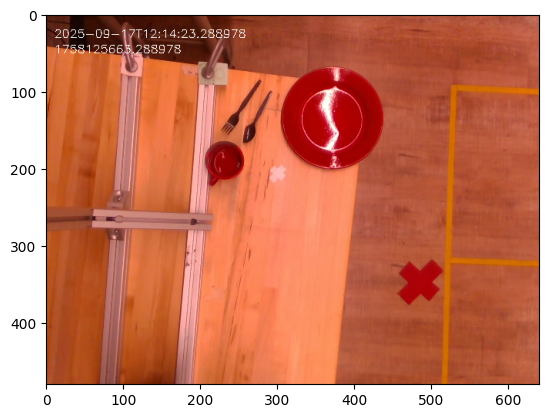

In [14]:
# Convert array to image
img_height, img_width, msg_data = get_img_height_width(bagfile=bagfile)
img_arr = msg_data.reshape((img_height, img_width, 3))
# img = Image.fromarray(img_arr)
img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

# Add timestamp overlay on image
font = cv2.FONT_HERSHEY_SIMPLEX
ts = datetime.datetime.now()
txt1 = ts.isoformat()
txt2 = str(ts.timestamp())
fontScale = 0.5
white = (255, 255, 255)
fontthickness = 1
cv2.putText(
    img=img,
    text=txt1,
    org=(10, 30),
    fontFace=font,
    fontScale=fontScale,
    color=white,
    thickness=fontthickness,
)
cv2.putText(
    img=img,
    text=txt2,
    org=(10, 50),
    fontFace=font,
    fontScale=fontScale,
    color=white,
    thickness=fontthickness,
)

plt.imshow(img)
plt.show()

In [15]:
extension = "mkv"
video_path = bagfile.parent / (bagfile.stem + "." + extension)
video_path

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.mkv')

In [16]:
def extract_video_from_bag(bagfile, fps=20):
    print("Extracting video from Bag file...")

    extension = "mkv"
    video_path = bagfile.parent / (bagfile.stem + "." + extension)

    # Initialize video writer
    img_height, img_width, _ = get_img_height_width(bagfile=bagfile)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Use 'mp4v' for MP4 format
    video = cv2.VideoWriter(
        filename=video_path, fourcc=fourcc, fps=fps, frameSize=(img_width, img_height)
    )

    # Create a type store to use if the bag has no message definitions.
    typestore = get_typestore(Stores.ROS1_NOETIC)

    # Create reader instance and open for reading.
    with AnyReader([bagfile], default_typestore=typestore) as reader:
        connections = [x for x in reader.connections if x.topic == "/imu_raw/Imu"]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            # print(msg.header.frame_id
            if connection.msgtype == "sensor_msgs/msg/Image":
                frame = msg.data.reshape((msg.height, msg.width, 3))

                current_ts = pd.to_datetime(timestamp, utc=True).tz_convert("EST")

                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Add timestamp overlay on image
                font = cv2.FONT_HERSHEY_SIMPLEX
                txt1 = current_ts.isoformat()
                txt2 = str(current_ts.timestamp())
                fontScale = 0.5
                white = (255, 255, 255)
                fontthickness = 1
                cv2.putText(
                    img=img,
                    text=txt1,
                    org=(10, 30),
                    fontFace=font,
                    fontScale=fontScale,
                    color=white,
                    thickness=fontthickness,
                )
                cv2.putText(
                    img=img,
                    text=txt2,
                    org=(10, 50),
                    fontFace=font,
                    fontScale=fontScale,
                    color=white,
                    thickness=fontthickness,
                )

                # Add images to the video
                video.write(img)

    # Release the video writer
    video.release()
    cv2.destroyAllWindows()
    print("Extracting video from Bag file: done ✓")
    print(f"Video path: {video_path}")
    return video_path

In [17]:
extract_video_from_bag(bagfile=bagfile, fps=20)

Extracting video from Bag file...
Extracting video from Bag file: done ✓
Video path: ../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.mkv


PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.mkv')

## Gripper data

In [18]:
gripper_pos = []

# Create a type store to use if the bag has no message definitions.
typestore = get_typestore(Stores.ROS1_NOETIC)

# Create reader instance and open for reading.
with AnyReader([bagfile], default_typestore=typestore) as reader:
    connections = [x for x in reader.connections if x.topic == "/imu_raw/Imu"]
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        msg = reader.deserialize(rawdata, connection.msgtype)
        # print(msg.header.frame_id
        if connection.msgtype == "ur5e_move/msg/gripper_pos":
            gripper_pos.append(msg.gripper_pos)
            print(msg)
            break
# gp = np.array(gripper_pos)
# np.unique(gp)

ur5e_move__msg__gripper_pos(header=std_msgs__msg__Header(seq=194605, stamp=builtin_interfaces__msg__Time(sec=1757375179, nanosec=428061485, __msgtype__='builtin_interfaces/msg/Time'), frame_id='', __msgtype__='std_msgs/msg/Header'), gripper_pos=1, __msgtype__='ur5e_move/msg/gripper_pos')


## Plot data

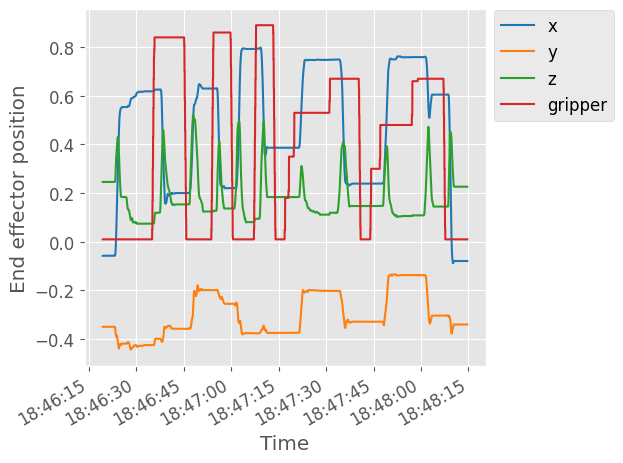

In [19]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors
    ax.plot(tf_df.timestamp, tf_df.x, label="x", color=cmap[0])
    ax.plot(tf_df.timestamp, tf_df.y, label="y", color=cmap[1])
    ax.plot(tf_df.timestamp, tf_df.z, label="z", color=cmap[2])
    ax.plot(gripper_df.timestamp, gripper_df.val, label="gripper", color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Plot all demos

In [20]:
bagfiles[-5:]

[PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

  0%|          | 0/5 [00:00<?, ?it/s]

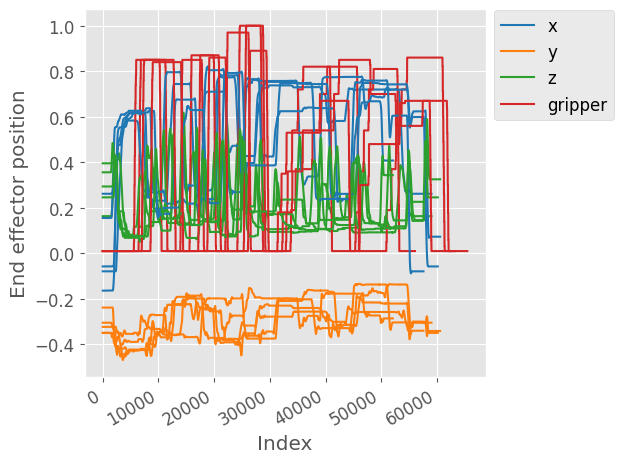

In [21]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    for idx, bagfile in enumerate(tqdm(bagfiles[-5:])):
        tf_df, gripper_df = extract_eef_data_from_rosbag(bagfile)
        if idx == 0:
            ax.plot(tf_df.index, tf_df.x, label="x", color=cmap[0])
            ax.plot(tf_df.index, tf_df.y, label="y", color=cmap[1])
            ax.plot(tf_df.index, tf_df.z, label="z", color=cmap[2])
            ax.plot(gripper_df.index, gripper_df.val, label="gripper", color=cmap[3])
        else:
            ax.plot(tf_df.index, tf_df.x, color=cmap[0])
            ax.plot(tf_df.index, tf_df.y, color=cmap[1])
            ax.plot(tf_df.index, tf_df.z, color=cmap[2])
            ax.plot(gripper_df.index, gripper_df.val, color=cmap[3])

    ax.set_xlabel("Index")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()